# Algorithm Chains and Pipelines

In [1]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

from IPython.display import display
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Overview

이번장에서는 pipeline을 사용해서 data cleaning, feature engineering, modeling 을 파이프라인으로 쉽게 할 수 있는 방법을 알아보겠습니다.

5장에서 배운 Hyperparameter Tuning도 함께 쓰는 연습도 하겠습니다.

## Building without pipeline

`cancer`예제를 봅시다. 아래처럼, 데이터를 불러오고 나서 아래처럼 직접 써줍니다.

    1. Scaling: `MinMaxScaler`
    2. Feature Engineering: `PCA`
    3. Model: `SVC`

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# 데이터 로딩
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 1. Scaling
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Feature Engineeirng
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. SVM
svm = SVC()
svm.fit(X_train_pca, y_train)

print("Test score: {:.2f}".format(svm.score(X_test_pca, y_test)))

Test score: 0.95


게다가, 각각의 스텝에서 최적의 parameter를 찾아주려면 `GridSearch`를 또 해야하죠.

## Pipelines with GridSearch

이제, `pipeline`을 사용하면 위의 코드가 반 이상 줄어듭니다. `boston`예제로 볼까요?

In [3]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# 데이터 로딩
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

# 파이프라인 만들기
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
pipe.fit(X_train, y_train)

print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.67


너무 쉽습니다. 게다가, grid search는 더 쉬워집니다.

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.77


코드가 너무 줄어듭니다. 간결한 코드를 만들기 위해서는 pipeline은 필수네요.

cross_validation 결과를 heatmap으로도 보시지요.

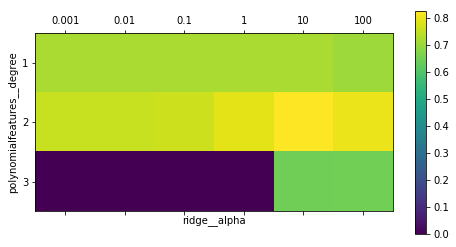

In [5]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])
plt.colorbar();

In [6]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


이 외에도 책에서는 중요하게 언급하는 것이 파이프라인을 사용하면, cross validation 을 할때 training data는 training에만 testing data는 testing 에만 정확히 사용한다는 장점이 있습니다. 아무래도 사람이 하면 실수할 수 있으니까요.

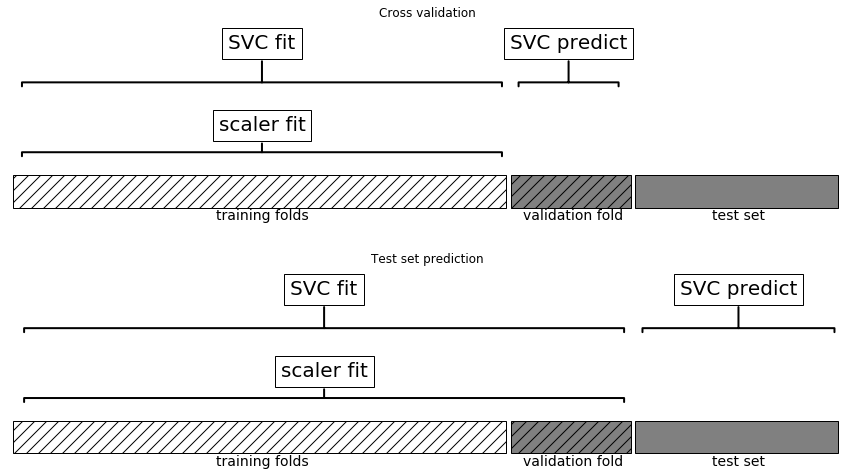

In [7]:
mglearn.plots.plot_proper_processing()

## Pipelins with multiple models

pipeline을 사용해서 여러 모델을 동시에 테스트도 가능합니다.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# 데이터 불러오기
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 파이프라인 구성
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

# Grid search with multiple models
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}
]
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
